In [101]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import csv
from imblearn import over_sampling
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn import over_sampling  
import numpy as np
import re
import os
import datetime as dt
import pickle
from datetime import datetime
from scipy import stats
import random
from sklearn.model_selection import KFold
from IPython.display import display, Markdown
import pickle
from pandas import Series
from collections import defaultdict
import math
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import f1_score, auc, accuracy_score, recall_score, precision_score,\
confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [103]:
train=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00421/aps_failure_training_set.csv',skiprows=range(0,20))


In [104]:
test= pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00421/aps_failure_test_set.csv',skiprows=range(0,20))

In [9]:
train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [105]:
train.replace(to_replace=['na','nan'],value = np.NaN,inplace=True)

In [106]:
test.replace(to_replace=['na','nan'],value = np.NaN,inplace=True)

In [90]:
train.columns.shape

(171,)

In [107]:
train.dropna(axis=1, thresh=train.shape[0]*0.7, inplace=True)

In [92]:
train.columns.shape

(161,)

In [93]:
test.columns.shape

(171,)

In [108]:
test.dropna(axis=1, thresh=test.shape[0]*0.7, inplace=True)

In [95]:
test.columns.shape

(161,)

In [119]:
y_test=test['class']
y_train=train['class']

In [97]:
train.drop(columns=['class'],inplace=True)
test.drop(columns=['class'],inplace=True)

In [110]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)
train_features = pd.DataFrame(scaler.transform(train), columns=train.columns)
test_features = pd.DataFrame(scaler.transform(test), columns=test.columns)

ValueError: could not convert string to float: 'neg'

In [113]:
#Impute median values of column to missing in the column 
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
impute_median = SimpleImputer(missing_values= np.nan, strategy='median',copy = True, verbose= 2)
train_median_imputed = pd.DataFrame(impute_median.fit_transform(train),columns=train.columns)
test_median_imputed = pd.DataFrame(impute_median.transform(test),columns=test.columns)

In [78]:
#Dimensionality Reduction - using Principal Component Analysis
pca = PCA(0.99) #Define how much variance to explain
pca.fit(train_median_imputed)
best_train_features = pca.transform(train_median_imputed)
best_train_features = pd.DataFrame(best_train_features)
best_test_features = pd.DataFrame(pca.transform(test_median_imputed))

In [67]:
pca.explained_variance_ratio_[:99].sum()

0.9900869901884582

In [73]:
print(f'Number of components {pca.n_components_}')

Number of components 49


In [74]:
best_train_features

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.355140,0.798910,0.120648,-0.049208,0.000452,-0.050267,-0.022237,0.035347,-0.037167,-0.038075,...,0.002275,0.020856,-0.003726,0.001566,-0.000274,0.004721,-0.002124,0.003673,-0.011311,0.001757
1,0.160828,-0.155515,-0.157159,0.683948,0.031814,0.056123,-0.019407,0.017964,-0.033843,0.002684,...,0.001193,0.000056,-0.000112,-0.001539,-0.000066,-0.001190,0.000562,-0.002588,-0.000576,-0.000109
2,-0.209456,-0.132490,-0.017636,0.000709,-0.002027,-0.015970,0.002707,-0.018347,0.016069,-0.005062,...,-0.000057,-0.002798,0.002014,0.000194,-0.001933,0.001361,0.000404,-0.001085,0.001530,-0.000549
3,-0.470749,-0.099167,-0.042105,-0.003382,0.002841,0.006489,-0.001579,0.001946,-0.001655,0.005851,...,0.000281,0.001358,0.001103,-0.000306,0.000537,-0.000692,-0.000226,0.001902,-0.000622,-0.002460
4,0.275400,-0.187207,-0.057750,-0.013029,-0.010997,-0.017924,-0.009987,0.027938,-0.054380,-0.024117,...,-0.004922,-0.005555,-0.003790,-0.000218,-0.000348,0.001469,0.000764,0.003183,-0.003416,-0.000086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.859762,-0.262376,-0.000611,-0.001195,0.013922,-0.061114,-0.030832,-0.005164,-0.040744,0.010784,...,0.002706,0.004962,0.001066,0.002929,-0.004806,0.009738,0.006976,-0.004333,0.005625,-0.002571
59996,-0.207734,0.873937,0.027891,-0.013474,0.004093,0.017648,0.001854,-0.001565,0.002616,0.012014,...,0.000405,-0.001188,-0.000903,0.000232,-0.000964,-0.001745,-0.001248,0.000047,0.000620,0.000106
59997,-0.327323,0.886171,0.049480,-0.015976,0.003689,0.016545,0.001118,0.002791,-0.002684,0.010016,...,0.000445,-0.000948,-0.000725,0.000341,-0.001285,-0.001580,-0.001313,0.000176,0.000135,0.000257
59998,-0.258202,0.861894,0.235349,-0.026041,0.009981,-0.070788,-0.037472,0.017951,0.014893,-0.031167,...,-0.011240,-0.010445,-0.004723,-0.000347,-0.006168,0.008305,0.010269,0.006850,-0.000999,0.000909


In [80]:
from sklearn.preprocessing import LabelEncoder

In [111]:
le = LabelEncoder()
train['class'] = le.fit_transform(train['class'])
test['class'] = le.fit_transform(test['class'])

In [114]:
#Undersampling the negative class
train_neg_sampled = train_median_imputed[train_median_imputed['class'] == 0].sample(n = 10000,random_state = 42)
train_Sampled = train_median_imputed[train_median_imputed['class'] == 1].append(train_neg_sampled)

In [115]:
train_Sampled

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
9,1.0,153204.0,1.820000e+02,126.0,0.0,0.0,0.0,0.0,0.0,11804.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
23,1.0,453236.0,2.926000e+03,126.0,0.0,0.0,0.0,0.0,222.0,323436.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
60,1.0,72504.0,1.594000e+03,1052.0,0.0,0.0,0.0,244.0,178226.0,1249396.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
115,1.0,762958.0,1.520000e+02,126.0,0.0,0.0,776.0,281128.0,2186308.0,8123016.0,...,233796.0,112086.0,221518.0,189988.0,92432.0,41098.0,3812.0,0.0,0.0,0.0
135,1.0,695994.0,1.520000e+02,126.0,0.0,0.0,0.0,0.0,0.0,55620.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56472,0.0,38300.0,5.880000e+02,550.0,0.0,0.0,0.0,0.0,0.0,0.0,...,295836.0,134706.0,252728.0,278584.0,194686.0,169626.0,282316.0,20252.0,0.0,0.0
24100,0.0,47980.0,7.000000e+01,66.0,0.0,0.0,0.0,0.0,0.0,0.0,...,365386.0,210418.0,521896.0,518492.0,298242.0,153558.0,129412.0,290.0,0.0,0.0
22879,0.0,42002.0,1.196000e+03,126.0,0.0,0.0,0.0,0.0,0.0,0.0,...,502164.0,226528.0,431696.0,314668.0,221120.0,118500.0,98848.0,842.0,0.0,0.0
52139,0.0,7212.0,2.130706e+09,94.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70746.0,31240.0,62238.0,52312.0,52300.0,31562.0,27214.0,542.0,0.0,0.0


In [121]:
# Upsampling the positive class using Smote Technique
sm = over_sampling.SMOTE()
train_Sampled_Smote, y_train = sm.fit_sample(train_Sampled,train_Sampled['class'])

In [123]:
train_Sampled_Smote

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,1.0,1.532040e+05,182.000000,126.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,1.180400e+04,...,1.298620e+05,2.687200e+04,3.404400e+04,2.247200e+04,3.436200e+04,0.000000e+00,0.000000e+00,0.000000,0.0,0.0
1,1.0,4.532360e+05,2926.000000,126.000000,0.0,0.0,0.000000,0.000000,2.220000e+02,3.234360e+05,...,7.908038e+06,3.026002e+06,5.025350e+06,2.025766e+06,1.160638e+06,5.338340e+05,4.938000e+05,6914.000000,0.0,0.0
2,1.0,7.250400e+04,1594.000000,1052.000000,0.0,0.0,0.000000,244.000000,1.782260e+05,1.249396e+06,...,1.432098e+06,3.722520e+05,5.275140e+05,3.582740e+05,3.328180e+05,2.841780e+05,3.742000e+03,0.000000,0.0,0.0
3,1.0,7.629580e+05,152.000000,126.000000,0.0,0.0,776.000000,281128.000000,2.186308e+06,8.123016e+06,...,2.337960e+05,1.120860e+05,2.215180e+05,1.899880e+05,9.243200e+04,4.109800e+04,3.812000e+03,0.000000,0.0,0.0
4,1.0,6.959940e+05,152.000000,126.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,5.562000e+04,...,1.397742e+06,4.955440e+05,3.616460e+05,2.861000e+04,5.130000e+03,2.120000e+02,0.000000e+00,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,4.216817e+05,68.921382,126.000000,0.0,0.0,0.000000,0.000000,6.718928e+04,7.784186e+05,...,5.944449e+05,2.303607e+05,5.411900e+05,1.152644e+06,1.239069e+06,2.950390e+05,4.475638e+04,0.000000,0.0,0.0
19996,1.0,2.183340e+05,136.247143,94.641300,0.0,0.0,0.000000,0.000000,0.000000e+00,8.769917e+03,...,9.945691e+04,2.146597e+04,2.881995e+04,1.994428e+04,3.043137e+04,1.160683e+04,2.642356e+02,0.000000,0.0,0.0
19997,1.0,8.824776e+05,1549.888772,126.000000,0.0,0.0,0.000000,19900.484878,4.598104e+05,5.494610e+06,...,3.665731e+06,1.670653e+06,4.848272e+06,1.642378e+07,1.038693e+07,2.073898e+06,9.506642e+04,24.262422,0.0,0.0
19998,1.0,2.315585e+05,296.774336,157.544867,0.0,0.0,0.000000,0.000000,2.453553e+03,1.282636e+05,...,2.650040e+06,8.207976e+05,6.209189e+05,1.672953e+05,5.924888e+04,1.844418e+04,1.284321e+03,0.000000,0.0,0.0


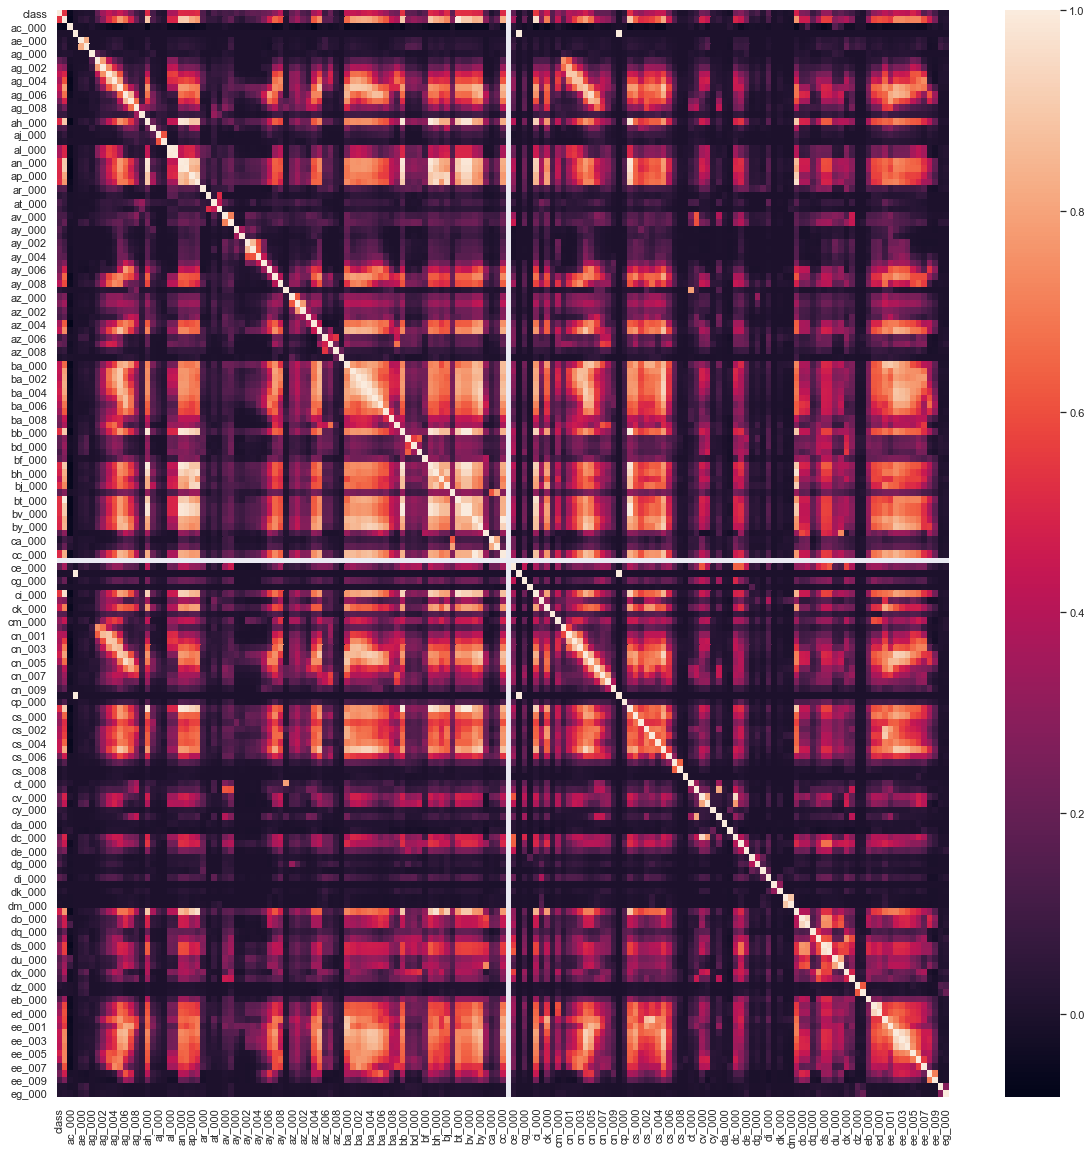

In [125]:
import seaborn as sns
#Plotting heat map for feature correlation from correlation matrix
corr_matrix = train_median_imputed.corr()
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corr_matrix, annot=False)
plt.show()

In [130]:
#Setting correlation coefficient threshold as 0.8 to remove highly correlated features in train data
#Reference: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.8)]
train_imp_features = train_median_imputed.drop(train_median_imputed[to_drop], axis=1)
train_imp_features.head()

,class,ac_000,af_000,ag_000,ag_001,ag_008,ag_009,ai_000,aj_000,ak_000,...,ee_000,ee_001,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,2.130706e+09,0.0,0.0,0.0,25896.0,0.0,0.0,0.0,0.0,...,965866.0,1706908.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.0,0.000000e+00,0.0,0.0,0.0,31642.0,0.0,0.0,68.0,0.0,...,664504.0,824154.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0.0,2.280000e+02,0.0,0.0,0.0,12016.0,0.0,0.0,0.0,0.0,...,262032.0,453378.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0.0,7.000000e+01,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5670.0,1566.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0.0,1.368000e+03,0.0,0.0,0.0,4588.0,0.0,0.0,226.0,0.0,...,404740.0,904230.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [132]:
from sklearn.decomposition import PCA   

In [155]:
#Performing standardization and PCA for dimensionality reduction
start = datetime.now()
std = StandardScaler()
train_std = std.fit_transform(train_median_imputed)
train_pca = PCA(n_components= 160,random_state=42)
print(train_pca.fit_transform(train_std))
print("Time required to run this cell", datetime.now() - start)

[[ 2.34800186e+00 -1.18956027e+00  1.92224300e+00 ... -2.86050498e-05
   2.00276003e-07  2.68165883e-07]
 [-6.33352531e-01 -5.56637971e-01  8.98226776e-02 ...  2.84310090e-06
   2.87423752e-07 -1.91222570e-08]
 [-1.21190519e+00 -1.08143207e-01 -2.67121691e-01 ... -1.72200753e-06
  -4.35099564e-08 -4.31000296e-08]
 ...
 [-3.20430215e+00  1.41068151e-01 -7.69377728e-01 ...  2.90954720e-07
  -2.40776361e-08  2.45342188e-09]
 [ 2.35894571e+00 -2.57967037e+00  2.15473960e+00 ...  1.58647954e-05
  -5.19227737e-07  1.79457248e-07]
 [-7.36372968e-01 -4.40185390e-01  2.96364272e-01 ... -2.74096148e-06
  -5.42538458e-08  2.16935957e-08]]
Time required to run this cell 0:00:02.264574


<function matplotlib.pyplot.show(*args, **kw)>

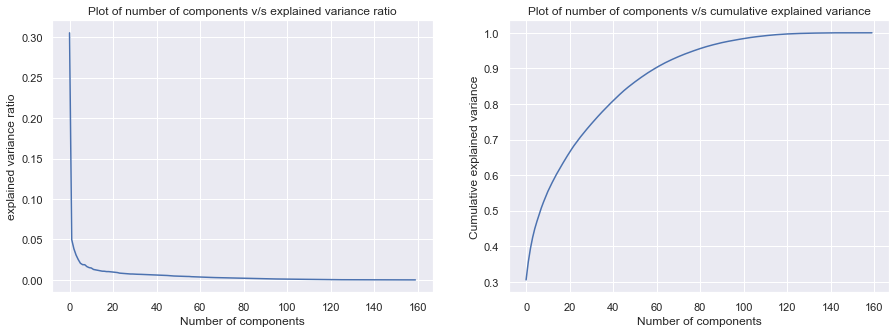

In [134]:
# Plot of number of features v/s explained variance ratio.
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=train_pca.explained_variance_ratio_)
plt.xlabel("Number of components")
plt.ylabel("explained variance ratio")
plt.title("Plot of number of components v/s explained variance ratio")
plt.subplot(1,2,2)
sns.lineplot(data=np.cumsum(train_pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Plot of number of components v/s cumulative explained variance")
plt.show

In [153]:
train_pca

PCA(n_components=160, random_state=42)

In [152]:
dict={} #selecting 90 features as they are  explaining 97% of data
for i in range(1,161):
    dict[f'{i} features']=train_pca.explained_variance_ratio_[:i].sum()

In [150]:
dict

{'1 features': 0.30536152985680326,
 '2 features': 0.3552121685475766,
 '3 features': 0.3936588191920717,
 '4 features': 0.4243689910755228,
 '5 features': 0.4494860619987978,
 '6 features': 0.4700587519115812,
 '7 features': 0.48889789724332705,
 '8 features': 0.5076485084756724,
 '9 features': 0.5240513684401329,
 '10 features': 0.5392244325982687,
 '11 features': 0.5539261406264544,
 '12 features': 0.5668465593946636,
 '13 features': 0.5792165290384902,
 '14 features': 0.5911536301892247,
 '15 features': 0.6025436678143429,
 '16 features': 0.6133278438067843,
 '17 features': 0.6240195221717237,
 '18 features': 0.6342967173357026,
 '19 features': 0.6445555841568612,
 '20 features': 0.6544543338443104,
 '21 features': 0.6641282802670267,
 '22 features': 0.6735638639015296,
 '23 features': 0.6826349365627224,
 '24 features': 0.6910086849794261,
 '25 features': 0.699173584599904,
 '26 features': 0.7072370085020873,
 '27 features': 0.7148904724782074,
 '28 features': 0.7224207568271646,


In [142]:
train_pca.explained_variance_ratio_[:90].sum()

0.9709175691870275

In [158]:
type(y_train)

pandas.core.series.Series

In [165]:
df1=pd.read_csv(r'D:\Scania-Truck-Failures\artifacts\preprocessed_data_dir\preprocessed_training_data.csv')

In [166]:
df2=pd.read_csv(r'D:\Scania-Truck-Failures\artifacts\target_column_data_dir\target_column_training_data.csv')

In [194]:
bigdata = pd.concat([df1, df2], ignore_index=True, sort=False)

In [179]:
df1

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,-2.388442,0.393916,-0.165964,-0.522237,0.476551,-0.365224,0.046489,0.092031,0.067021,-0.226966,...,-0.377547,-0.078989,0.090030,-0.022637,-0.075323,-0.014717,-0.033755,0.081180,-0.170167,-0.040291
1,2.957139,-0.603366,5.138782,0.145475,0.753974,0.043161,-1.875024,0.823056,1.313589,-1.320917,...,-0.789499,0.406102,0.181730,0.168659,0.060714,-0.435608,-0.174282,-0.728576,0.669708,1.046065
2,-1.766432,0.736955,0.010351,-0.463367,0.331939,0.104443,0.041834,-0.675273,-0.114561,0.459287,...,0.029673,-0.065333,-0.129818,0.020562,0.099913,-0.078455,0.201191,-0.067713,-0.025527,-0.051820
3,-0.282988,-0.056117,-2.115051,-1.167922,0.064318,0.870985,-0.239251,-0.721535,1.787279,-0.663009,...,-0.176851,0.943707,-0.044890,0.328876,-0.226667,0.702830,0.721487,-0.700394,0.745948,0.156727
4,-2.277329,-0.613842,-0.358355,0.021128,0.679697,0.308310,0.104164,0.150864,-0.293447,-0.582393,...,0.051876,-0.037894,0.093995,-0.014412,0.007880,-0.060577,-0.091318,-0.149398,-0.009625,-0.084627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2.712364,-1.272523,-2.482925,1.516775,0.073431,-0.148195,0.216913,0.428487,-0.510748,-0.312884,...,-0.089357,-0.528320,0.574255,0.453273,-1.077292,0.576570,1.033245,-0.050220,0.182082,-0.625174
19996,5.067478,3.011493,2.620392,-3.408775,0.639082,2.526815,-1.050693,-0.166363,0.160324,-3.339146,...,-0.165413,-0.286247,-0.207141,-0.286510,0.090754,0.264679,0.220798,0.396915,0.273001,-0.235608
19997,3.577047,-4.255217,-0.015708,1.523358,-0.936761,0.800112,0.606077,-0.200113,-0.205028,0.037733,...,0.315848,0.078013,-0.832455,-0.146039,0.267820,0.264826,-0.128273,0.276201,0.080765,0.491109
19998,-1.015302,1.862835,0.349286,-1.634426,1.022088,-1.583214,-1.987094,0.667422,-2.390733,5.399872,...,-1.534857,-1.174621,-0.107906,-0.283969,0.112628,-0.026103,-0.343277,0.773066,-0.909172,-0.622527


In [183]:
from sklearn.model_selection import train_test_split

In [191]:
x_train,y_train,x_test,y_test=train_test_split(df1,df2)

In [189]:
x_test

,class
10389,0.0
9679,0.0
5613,0.0
14847,1.0
14725,1.0
...,...
5107,0.0
19942,1.0
14429,1.0
11977,1.0


In [ ]:
#### Model Buliding

In [31]:
### @author: Ankit Sharma
from sklearn.ensemble import RandomForestClassifier

# from src.utils.all_utils import read_yaml, create_directory_path, save_local_df
import argparse
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer,MissingIndicator
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn import over_sampling
from sklearn.decomposition import PCA
import pickle as p
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics  import roc_auc_score,accuracy_score
import xgboost as xgb

In [1]:



class ModelTraining:
    def __init__(self,config_path,params_path):
        # self.file_object = file_object
        # self.logger_object = logger_object
        self.clf = RandomForestClassifier()
        self.xgb = XGBClassifier()
        self.config = read_yaml(config_path)
        self.params = read_yaml(params_path)
        self.split_ratio = self.params["base"]["test_size"]
        self.random_state = self.params["base"]["random_state"]
        self.artifacts_dir = self.config["artifacts"]['artifacts_dir']
        self.preprocessed_data_dir = self.config["artifacts"]["preprocessed_data_dir"]
        self.target_column_data_dir = self.config['artifacts']['target_column_data_dir']
        self.preprocessed_data_file = self.config["artifacts"]["preprocessed_data_file"]
        self.target_column_data_file = self.config["artifacts"]["target_column_data_file"]
        self.preprocessed_data_path = os.path.join(self.artifacts_dir, self.preprocessed_data_dir, self.preprocessed_data_file)
        self.target_column_data_path = os.path.join(self.artifacts_dir, self.target_column_data_dir, self.target_column_data_file)

    def get_best_params_for_xgboost(self, train_x, train_y):

        """
                                        Method Name: get_best_params_for_xgboost
                                        Description: get the parameters for XGBoost Algorithm which give the best accuracy.
                                                     Use Hyper Parameter Tuning.
                                        Output: The model with the best parameters
                                        On Failure: Raise Exception

                                        Written By: Ankit Sharma
                                        Version: 1.0
                                        Revisions: None

                                """
        # self.logger_object.log(self.file_object,
        #                        'Entered the get_best_params_for_xgboost method of the Model_Finder class')
        try:
            # initializing with different combination of parameters
            self.param_grid_xgboost = {

                'learning_rate': [0.5, 0.1, 0.01, 0.001],
                'max_depth': [3, 5, 10, 20],
                'n_estimators': [10, 50, 100, 200]

            }
            # Creating an object of the Grid Search class
            self.grid = GridSearchCV(XGBClassifier(), self.param_grid_xgboost, verbose=3,
                                     cv=5)
            # finding the best parameters
            self.grid.fit(train_x, train_y)

            # extracting the best parameters
            self.learning_rate = self.grid.best_params_['learning_rate']
            self.max_depth = self.grid.best_params_['max_depth']
            self.n_estimators = self.grid.best_params_['n_estimators']

            # creating a new model with the best parameters
            self.xgb = XGBClassifier(learning_rate=self.learning_rate, max_depth=self.max_depth,
                                     n_estimators=self.n_estimators)
            # training the mew model
            self.xgb.fit(train_x, train_y)
            # self.logger_object.log(self.file_object,
            #                        'XGBoost best params: ' + str(
            #                            self.grid.best_params_) + '. Exited the get_best_params_for_xgboost method of the Model_Finder class')
            return self.xgb
        except Exception as e:
            # self.logger_object.log(self.file_object,
            #                        'Exception occured in get_best_params_for_xgboost method of the Model_Finder class. Exception message:  ' + str(
            #                            e))
            # self.logger_object.log(self.file_object,
            #                        'XGBoost Parameter tuning  failed. Exited the get_best_params_for_xgboost method of the Model_Finder class')
            print(e)
            raise Exception()

    def get_best_params_for_random_forest(self,train_x,train_y):
        """
                                Method Name: get_best_params_for_random_forest
                                Description: get the parameters for Random Forest Algorithm which give the best accuracy.
                                             Use Hyper Parameter Tuning.
                                Output: The model with the best parameters
                                On Failure: Raise Exception

                                Written By: Ankit Sharma
                                Version: 1.0
                                Revisions: None

                        """

        try:
            # initializing with different combination of parameters
            self.param_grid = {"n_estimators": [10, 50, 100, 130], "criterion": ['gini', 'entropy'],
                               "max_depth": range(2, 4, 1), "max_features": ['auto', 'log2']}

            #Creating an object of the Grid Search class
            self.grid = GridSearchCV(estimator=self.clf, param_grid=self.param_grid, cv=5,  verbose=3)
            #finding the best parameters
            self.grid.fit(train_x, train_y)

            #extracting the best parameters
            self.criterion = self.grid.best_params_['criterion']
            self.max_depth = self.grid.best_params_['max_depth']
            self.max_features = self.grid.best_params_['max_features']
            self.n_estimators = self.grid.best_params_['n_estimators']
            self.clf = RandomForestClassifier(n_estimators=self.n_estimators, criterion=self.criterion,
                                          max_depth=self.max_depth, max_features=self.max_features)
            # training the mew model
            self.clf.fit(train_x, train_y)

            return self.clf
        except Exception as e:
            # self.logger_object.log(self.file_object,
            #                    'Exception occured in get_best_params_for_random_forest method of the Model_Finder class. Exception message:  ' + str(
            #                        e))
            # self.logger_object.log(self.file_object,
            #                    'Random Forest Parameter tuning  failed. Exited the get_best_params_for_random_forest method of the Model_Finder class')
            print(e)
            raise Exception()

    def start_model_training(self):
        self.training_data=pd.read_csv(self.preprocessed_data_path)
        self.target_column_data=pd.read_csv(self.target_column_data_path)
        self.x_train,self.x_test,self.y_train,self.y_test=train_test_split(self.training_data,self.target_column_data,test_size=self.split_ratio, random_state=self.random_state)
        # print(f"x train shape:{self.x_train.shape}")
        # print(f"y train shape:{self.y_train.shape}")
        # print(f"x test shape:{self.x_test.shape}")
        # print(f"y test shape:{self.y_test.shape}")
        # self.get_best_params_for_random_forest(self.x_train,self.y_train.flatten())
        self.get_best_params_for_xgboost(self.x_train,self.y_train)

if __name__ == '__main__':
    args = argparse.ArgumentParser()

    args.add_argument("--config", "-c", default="config/config.yaml")
    args.add_argument("--params", "-p", default="config/params.yaml")

    parsed_args = args.parse_args()
    model_training=ModelTraining(config_path=parsed_args.config, params_path=parsed_args.params)
    model_training.start_model_training()


ModuleNotFoundError: No module named 'src.utils'

In [1]:
import pandas as pd
import pickle as p

In [2]:
training=pd.read_csv(r"D:\Scania-Truck-Failures\artifacts\preprocessed_data_dir\preprocessed_training_data.csv")
target_column=pd.read_csv(r'D:\Scania-Truck-Failures\artifacts\target_column_data_dir\target_column_training_data.csv')

In [41]:
training[1000:1001]

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
1000,-0.306154,-0.140883,-0.011577,-0.706156,-0.00354,-0.296781,0.149672,-0.028839,-0.004063,-0.070124,...,-0.20595,0.002854,-0.047054,-0.093903,0.031411,-0.031478,-0.025966,-0.007777,0.071413,-0.048394


In [37]:
target_column[target_column['class']==0]

,class
1000,0.0
1001,0.0
1002,0.0
1003,0.0
1004,0.0
...,...
10995,0.0
10996,0.0
10997,0.0
10998,0.0


In [4]:
f=open(r"D:\Scania-Truck-Failures\artifacts\model_dir\Xg-Boost.pkl",'rb')
xgb=p.load(f)

In [43]:
xgb.predict(training[1000:1002])

array([0., 0.])

In [15]:
f=open(r"D:\Scania-Truck-Failures\artifacts\model_dir\Random Forest.pkl",'rb')
p.load(f)

RandomForestClassifier(criterion='entropy', max_depth=3)

In [63]:
!python --version

Python 3.8.3


In [62]:
xgb.__version__

'0.90'

In [67]:
test=r"D:\Scania-Truck-Failures\artifacts\preprocessed_data_dir\preprocessed_testing_data.csv"

In [68]:
test=pd.read_csv(test)

In [69]:
test.shape

(20000, 90)

In [70]:
import pickle

In [71]:
label=pd.read_csv(r"D:\Scania-Truck-Failures\artifacts\target_column_data_dir\target_column_testing_data.csv")

In [75]:
model=pickle.load(open(r"D:\Scania-Truck-Failures\artifacts\model_dir\Xg-Boost.pkl",'rb'))

In [77]:
model.predict(test)

array([1., 1., 1., ..., 1., 1., 1.])

In [86]:
for i in range(0,len(test)):
  print(f"Actual Output:{label.iloc[i]},Predicted Output:{model.predict(test.iloc[[i]])}")

Actual Output:class    1.0
Name: 0, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 1, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 2, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 3, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 4, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 5, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 6, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 7, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 8, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 9, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13, dtype: floa

Actual Output:class    1.0
Name: 131, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 132, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 133, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 134, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 135, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 136, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 137, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 138, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 139, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 140, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 141, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 142, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 143, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.

Actual Output:class    1.0
Name: 256, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 257, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 258, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 259, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 260, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 261, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 262, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 263, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 264, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 265, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 266, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 267, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 268, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.

Actual Output:class    0.0
Name: 388, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 389, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 390, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 391, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 392, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 393, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 394, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 395, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 396, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 397, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 398, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 399, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 400, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.

Actual Output:class    0.0
Name: 523, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 524, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 525, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 526, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 527, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 528, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 529, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 530, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 531, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 532, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 533, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 534, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 535, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.

Actual Output:class    0.0
Name: 633, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 634, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 635, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 636, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 637, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 638, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 639, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 640, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 641, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 642, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 643, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 644, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 645, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.

Actual Output:class    0.0
Name: 765, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 766, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 767, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 768, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 769, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 770, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 771, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 772, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 773, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 774, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 775, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 776, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 777, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.

Actual Output:class    0.0
Name: 897, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 898, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 899, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 900, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 901, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 902, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 903, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 904, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 905, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 906, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 907, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 908, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 909, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.

Actual Output:class    0.0
Name: 1026, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1027, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1028, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1029, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1030, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1031, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1032, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1033, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1034, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1035, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1036, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1037, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1038, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 1135, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1136, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1137, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1138, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1139, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1140, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1141, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1142, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1143, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1144, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1145, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1146, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1147, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 1266, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1267, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1268, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1269, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1270, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1271, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1272, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1273, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1274, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1275, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1276, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1277, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1278, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 1375, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1376, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1377, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1378, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1379, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1380, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1381, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1382, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1383, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1384, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1385, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1386, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1387, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 1483, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1484, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1485, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1486, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1487, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1488, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1489, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1490, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1491, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1492, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1493, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1494, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1495, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 1613, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1614, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1615, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1616, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1617, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1618, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1619, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1620, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1621, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 1622, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1623, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1624, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1625, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 1723, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1724, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1725, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1726, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1727, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1728, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1729, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1730, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1731, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1732, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1733, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1734, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1735, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 1831, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1832, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1833, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1834, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1835, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1836, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1837, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1838, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1839, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1840, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1841, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1842, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1843, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 1952, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1953, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1954, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1955, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1956, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1957, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1958, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1959, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1960, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1961, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1962, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1963, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 1964, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 2084, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2085, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2086, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2087, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2088, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2089, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2090, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2091, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2092, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2093, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2094, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2095, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2096, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 2211, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2212, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2213, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2214, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2215, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2216, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2217, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2218, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2219, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2220, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2221, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2222, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2223, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 2320, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2321, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2322, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2323, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2324, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2325, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2326, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2327, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2328, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2329, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2330, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2331, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2332, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 2452, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2453, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2454, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2455, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2456, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2457, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2458, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2459, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2460, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2461, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2462, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2463, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2464, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 2584, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2585, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2586, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2587, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2588, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2589, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2590, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2591, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2592, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2593, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2594, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2595, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2596, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 2715, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2716, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2717, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2718, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2719, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2720, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2721, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2722, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2723, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2724, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2725, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2726, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2727, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 2824, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2825, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2826, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2827, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2828, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2829, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2830, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2831, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2832, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2833, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2834, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2835, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2836, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 2958, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2959, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2960, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2961, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2962, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2963, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2964, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2965, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2966, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2967, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2968, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2969, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 2970, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 3094, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3095, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3096, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3097, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3098, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3099, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3100, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3101, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3102, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3103, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3104, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3105, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3106, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 3206, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3207, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3208, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3209, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3210, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3211, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3212, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3213, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3214, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3215, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3216, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3217, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3218, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 3319, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3320, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3321, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3322, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3323, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3324, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3325, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3326, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3327, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3328, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3329, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3330, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3331, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 3433, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3434, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3435, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3436, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3437, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3438, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3439, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3440, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3441, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3442, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3443, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3444, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3445, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 3547, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3548, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3549, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3550, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3551, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3552, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3553, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3554, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3555, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3556, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3557, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3558, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3559, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 3660, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3661, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3662, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3663, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3664, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3665, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3666, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3667, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3668, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3669, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3670, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3671, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3672, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 3773, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3774, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3775, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3776, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3777, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3778, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3779, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3780, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3781, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3782, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3783, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3784, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 3785, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 3884, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3885, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 3886, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3887, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3888, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3889, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3890, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3891, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3892, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3893, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3894, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3895, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3896, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 3998, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 3999, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4000, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4001, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4002, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4003, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4004, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4005, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4006, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4007, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4008, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4009, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4010, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 4110, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4111, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4112, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4113, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4114, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4115, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4116, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4117, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4118, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4119, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4120, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4121, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4122, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 4223, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4224, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4225, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4226, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4227, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 4228, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4229, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4230, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4231, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4232, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4233, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4234, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4235, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 4336, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4337, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4338, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4339, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4340, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4341, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4342, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4343, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4344, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4345, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4346, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4347, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4348, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 4449, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4450, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4451, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4452, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4453, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4454, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4455, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4456, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4457, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4458, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4459, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4460, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4461, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 4563, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4564, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4565, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4566, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4567, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4568, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4569, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4570, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4571, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4572, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4573, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4574, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4575, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 4676, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4677, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4678, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4679, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4680, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4681, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4682, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4683, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4684, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4685, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4686, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4687, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4688, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 4788, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4789, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4790, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4791, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4792, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4793, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4794, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4795, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4796, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4797, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4798, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4799, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4800, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 4901, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4902, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4903, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4904, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4905, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4906, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4907, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4908, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4909, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4910, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4911, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4912, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 4913, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 5015, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5016, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5017, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5018, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5019, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5020, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5021, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5022, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5023, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5024, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5025, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5026, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5027, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 5128, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5129, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5130, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5131, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5132, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5133, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5134, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5135, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5136, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5137, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5138, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5139, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5140, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 5242, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5243, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5244, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5245, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5246, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5247, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5248, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5249, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5250, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5251, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5252, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5253, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5254, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 5356, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5357, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5358, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5359, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5360, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5361, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5362, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5363, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5364, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5365, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 5366, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5367, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5368, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 5470, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5471, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5472, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5473, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5474, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5475, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5476, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5477, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5478, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5479, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5480, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5481, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5482, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 5584, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5585, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5586, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5587, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5588, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5589, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5590, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5591, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5592, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5593, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5594, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5595, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5596, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 5694, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 5695, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5696, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5697, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5698, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5699, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5700, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5701, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5702, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5703, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5704, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5705, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5706, dtype: float64,Predicted Output:[0.]
Actual Outpu

Name: 5802, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5803, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5804, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5805, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5806, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5807, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5808, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5809, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5810, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5811, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5812, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5813, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5814, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5815, 

Name: 5937, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5938, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5939, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 5940, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5941, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5942, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5943, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5944, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5945, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5946, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5947, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5948, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5949, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 5950, 

Actual Output:class    0.0
Name: 6048, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6049, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6050, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6051, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6052, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6053, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6054, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6055, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6056, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6057, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6058, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6059, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6060, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 6159, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6160, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6161, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6162, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6163, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6164, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6165, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6166, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6167, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6168, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6169, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6170, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6171, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 6268, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6269, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6270, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6271, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6272, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6273, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6274, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6275, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6276, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6277, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6278, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6279, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6280, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 6382, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6383, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6384, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6385, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6386, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6387, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6388, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6389, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6390, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6391, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6392, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6393, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6394, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 6494, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6495, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6496, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 6497, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6498, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6499, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6500, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6501, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6502, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6503, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6504, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6505, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6506, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 6607, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6608, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6609, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6610, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6611, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6612, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6613, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6614, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6615, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6616, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6617, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6618, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6619, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 6720, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6721, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6722, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6723, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6724, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6725, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6726, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6727, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6728, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 6729, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6730, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6731, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 6732, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 6834, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6835, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6836, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6837, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6838, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6839, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6840, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6841, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6842, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6843, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6844, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6845, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6846, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 6948, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6949, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6950, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6951, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6952, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6953, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6954, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6955, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6956, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6957, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6958, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6959, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 6960, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 7058, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7059, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7060, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7061, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7062, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 7063, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7064, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7065, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7066, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7067, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7068, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7069, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7070, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 7168, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7169, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7170, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7171, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 7172, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7173, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7174, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7175, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7176, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7177, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7178, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7179, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7180, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 7282, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7283, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7284, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7285, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7286, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7287, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7288, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7289, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7290, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7291, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7292, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7293, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7294, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 7394, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7395, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7396, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7397, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7398, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7399, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7400, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7401, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7402, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7403, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7404, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7405, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7406, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 7507, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7508, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7509, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7510, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 7511, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7512, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7513, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7514, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7515, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7516, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7517, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7518, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7519, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 7621, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7622, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7623, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7624, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7625, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7626, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7627, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7628, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7629, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7630, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7631, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7632, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7633, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 7734, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7735, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7736, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7737, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7738, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7739, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 7740, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7741, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7742, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7743, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7744, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7745, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7746, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 7848, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7849, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7850, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7851, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7852, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7853, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7854, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7855, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7856, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7857, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7858, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7859, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7860, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 7962, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7963, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7964, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7965, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7966, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7967, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7968, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7969, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7970, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7971, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7972, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7973, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 7974, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 8075, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8076, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8077, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8078, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8079, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8080, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8081, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8082, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8083, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8084, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8085, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8086, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8087, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 8188, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8189, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8190, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8191, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8192, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8193, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8194, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8195, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8196, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8197, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8198, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8199, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8200, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 8301, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8302, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8303, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8304, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8305, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8306, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8307, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8308, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8309, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8310, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8311, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8312, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8313, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 8435, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8436, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8437, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8438, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8439, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8440, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8441, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8442, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8443, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8444, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8445, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8446, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8447, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 8545, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8546, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8547, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8548, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8549, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8550, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8551, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8552, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8553, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8554, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8555, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8556, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8557, dtype: float64,Predicted Output:[0.]
Actual Outpu

Name: 8658, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8659, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8660, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8661, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8662, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8663, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8664, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8665, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8666, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8667, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8668, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8669, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8670, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8671, 

Actual Output:class    0.0
Name: 8773, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8774, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8775, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8776, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8777, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8778, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8779, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8780, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8781, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8782, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8783, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8784, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8785, dtype: float64,Predicted Output:[0.]
Actual Outpu

Name: 8885, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8886, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8887, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8888, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8889, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8890, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8891, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8892, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8893, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8894, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8895, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8896, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8897, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 8898, 

Actual Output:class    0.0
Name: 9000, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9001, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9002, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9003, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9004, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9005, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9006, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9007, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9008, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9009, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9010, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9011, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9012, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 9112, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9113, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9114, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9115, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9116, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 9117, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9118, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9119, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9120, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9121, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9122, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9123, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9124, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 9226, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 9227, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9228, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9229, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9230, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9231, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9232, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9233, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9234, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9235, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9236, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9237, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9238, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 9339, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9340, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9341, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9342, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9343, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9344, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9345, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9346, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9347, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9348, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9349, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9350, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9351, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 9451, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9452, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9453, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9454, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9455, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9456, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9457, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9458, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9459, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9460, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9461, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9462, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9463, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 9563, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9564, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9565, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9566, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9567, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9568, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9569, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9570, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9571, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9572, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9573, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9574, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9575, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 9677, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9678, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9679, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9680, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9681, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9682, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9683, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9684, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9685, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9686, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9687, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9688, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9689, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 9791, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9792, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9793, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9794, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9795, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9796, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9797, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9798, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9799, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9800, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9801, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9802, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9803, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 9900, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9901, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9902, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9903, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9904, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9905, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9906, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9907, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9908, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9909, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9910, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9911, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 9912, dtype: float64,Predicted Output:[0.]
Actual Outpu

Actual Output:class    0.0
Name: 10010, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10011, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10012, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10013, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10014, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10015, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10016, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10017, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10018, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10019, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10020, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10021, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10022, dtype: float64,Predicted Output:[0.]

Actual Output:class    0.0
Name: 10121, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10122, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10123, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10124, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10125, dtype: float64,Predicted Output:[1.]
Actual Output:class    0.0
Name: 10126, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10127, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10128, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10129, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10130, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10131, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10132, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10133, dtype: float64,Predicted Output:[0.]

Actual Output:class    0.0
Name: 10234, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10235, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10236, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10237, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10238, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10239, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10240, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10241, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10242, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10243, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10244, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10245, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10246, dtype: float64,Predicted Output:[0.]

Actual Output:class    0.0
Name: 10347, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10348, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10349, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10350, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10351, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10352, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10353, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10354, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10355, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10356, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10357, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10358, dtype: float64,Predicted Output:[0.]
Actual Output:class    0.0
Name: 10359, dtype: float64,Predicted Output:[0.]

Actual Output:class    1.0
Name: 10461, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10462, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10463, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10464, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10465, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10466, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10467, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10468, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10469, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10470, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10471, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10472, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 10473, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 10572, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10573, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10574, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10575, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10576, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10577, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10578, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10579, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10580, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 10581, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10582, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10583, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10584, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 10685, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10686, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10687, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10688, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 10689, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10690, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10691, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10692, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10693, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10694, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10695, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10696, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10697, dtype: float64,Predicted Output:[1.]

Name: 10797, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10798, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10799, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10800, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10801, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10802, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10803, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10804, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10805, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10806, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10807, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10808, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10809, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0

Actual Output:class    1.0
Name: 10908, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10909, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10910, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10911, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10912, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10913, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10914, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10915, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10916, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10917, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10918, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10919, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 10920, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 11024, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11025, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11026, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11027, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11028, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11029, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11030, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11031, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11032, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11033, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11034, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11035, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11036, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 11135, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11136, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11137, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11138, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11139, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11140, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11141, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11142, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11143, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11144, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11145, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11146, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11147, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 11248, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11249, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11250, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11251, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11252, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11253, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11254, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11255, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11256, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11257, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11258, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11259, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11260, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 11359, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11360, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11361, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11362, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11363, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11364, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11365, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11366, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 11367, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11368, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11369, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11370, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11371, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 11472, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11473, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 11474, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11475, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11476, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11477, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11478, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11479, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 11480, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11481, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11482, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11483, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11484, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 11584, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11585, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11586, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11587, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11588, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11589, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11590, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11591, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11592, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11593, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 11594, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11595, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11596, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 11695, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11696, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11697, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11698, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11699, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11700, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11701, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11702, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11703, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11704, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11705, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11706, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11707, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 11806, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11807, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11808, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11809, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11810, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11811, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11812, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11813, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11814, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11815, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11816, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11817, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11818, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 11918, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11919, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11920, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11921, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11922, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11923, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11924, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11925, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11926, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11927, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11928, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11929, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 11930, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 12029, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12030, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12031, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12032, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12033, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12034, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 12035, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12036, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12037, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12038, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12039, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12040, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12041, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 12143, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12144, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12145, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12146, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12147, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12148, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12149, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12150, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12151, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12152, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12153, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12154, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12155, dtype: float64,Predicted Output:[1.]

Name: 12254, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12255, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12256, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12257, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12258, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12259, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12260, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12261, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 12262, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12263, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12264, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12265, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12266, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0

Actual Output:class    1.0
Name: 12367, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12368, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12369, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12370, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12371, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12372, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12373, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12374, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12375, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12376, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12377, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12378, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12379, dtype: float64,Predicted Output:[0.]

Actual Output:class    1.0
Name: 12477, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12478, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12479, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12480, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12481, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12482, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12483, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12484, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12485, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12486, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12487, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12488, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12489, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 12586, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12587, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12588, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12589, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12590, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12591, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12592, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12593, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12594, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12595, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12596, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12597, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12598, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 12698, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12699, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12700, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 12701, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12702, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12703, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12704, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12705, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12706, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12707, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12708, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12709, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12710, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 12811, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12812, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12813, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12814, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12815, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12816, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12817, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12818, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12819, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12820, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 12821, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12822, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12823, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 12924, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12925, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 12926, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12927, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12928, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12929, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12930, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12931, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12932, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12933, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12934, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12935, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 12936, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 13037, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13038, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13039, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13040, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13041, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13042, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13043, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13044, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13045, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13046, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13047, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13048, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13049, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 13150, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13151, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13152, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13153, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13154, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13155, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13156, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13157, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13158, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13159, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13160, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13161, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13162, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 13263, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13264, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13265, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13266, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13267, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13268, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13269, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13270, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13271, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13272, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13273, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13274, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13275, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 13374, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13375, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13376, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13377, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13378, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13379, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13380, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13381, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13382, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13383, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13384, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13385, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13386, dtype: float64,Predicted Output:[1.]

Name: 13508, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13509, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13510, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13511, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13512, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13513, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13514, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13515, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13516, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13517, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13518, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13519, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13520, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0

Actual Output:class    1.0
Name: 13620, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13621, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13622, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13623, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13624, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13625, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13626, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13627, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13628, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13629, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13630, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13631, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13632, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 13734, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13735, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 13736, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13737, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13738, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13739, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13740, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13741, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13742, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13743, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13744, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13745, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13746, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 13843, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13844, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 13845, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13846, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13847, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13848, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13849, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 13850, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13851, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13852, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13853, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13854, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13855, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 13956, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13957, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13958, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13959, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13960, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13961, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13962, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13963, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13964, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13965, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13966, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13967, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 13968, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 14068, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14069, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14070, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14071, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14072, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14073, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14074, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14075, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14076, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14077, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14078, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14079, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14080, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 14181, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14182, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14183, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14184, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14185, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14186, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14187, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14188, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14189, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 14190, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14191, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14192, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14193, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 14292, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14293, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14294, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14295, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14296, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14297, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14298, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14299, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14300, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14301, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14302, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14303, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14304, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 14404, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14405, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14406, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14407, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14408, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14409, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14410, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14411, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14412, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14413, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14414, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14415, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14416, dtype: float64,Predicted Output:[0.]

Actual Output:class    1.0
Name: 14516, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14517, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14518, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14519, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14520, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14521, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14522, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14523, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14524, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14525, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14526, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14527, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14528, dtype: float64,Predicted Output:[1.]

Name: 14627, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14628, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14629, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14630, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14631, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14632, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14633, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14634, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14635, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14636, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14637, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14638, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14639, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0

Actual Output:class    1.0
Name: 14739, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14740, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14741, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14742, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14743, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14744, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14745, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14746, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14747, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14748, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14749, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14750, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14751, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 14872, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14873, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14874, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14875, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14876, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14877, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14878, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14879, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14880, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14881, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14882, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14883, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 14884, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 15002, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15003, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15004, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15005, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15006, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15007, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15008, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15009, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15010, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15011, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15012, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15013, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15014, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 15134, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15135, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15136, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15137, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15138, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15139, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15140, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15141, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15142, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15143, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15144, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15145, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15146, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 15245, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15246, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15247, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15248, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15249, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15250, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15251, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15252, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15253, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15254, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15255, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15256, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15257, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 15356, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15357, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15358, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15359, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15360, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15361, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15362, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15363, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15364, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15365, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15366, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 15367, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15368, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 15467, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15468, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15469, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15470, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15471, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15472, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15473, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15474, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15475, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15476, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15477, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15478, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15479, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 15576, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15577, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15578, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15579, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15580, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 15581, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15582, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15583, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15584, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15585, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15586, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15587, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15588, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 15688, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15689, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15690, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15691, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15692, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 15693, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15694, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15695, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15696, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15697, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15698, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15699, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15700, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 15796, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15797, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15798, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15799, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15800, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15801, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15802, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15803, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15804, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15805, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15806, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15807, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 15808, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 15906, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15907, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15908, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15909, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15910, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 15911, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15912, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15913, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15914, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15915, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15916, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15917, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 15918, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 16034, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16035, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16036, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16037, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16038, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16039, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16040, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16041, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16042, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16043, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16044, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 16045, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16046, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 16162, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16163, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16164, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16165, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 16166, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16167, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16168, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16169, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16170, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16171, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16172, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 16173, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16174, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 16275, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16276, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16277, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16278, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16279, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16280, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16281, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 16282, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16283, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16284, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16285, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16286, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16287, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 16388, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16389, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16390, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16391, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16392, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16393, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16394, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16395, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16396, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16397, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16398, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16399, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16400, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 16500, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16501, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16502, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16503, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16504, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16505, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16506, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16507, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16508, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16509, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16510, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16511, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16512, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 16613, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16614, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16615, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16616, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16617, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16618, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16619, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16620, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16621, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16622, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16623, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16624, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16625, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 16726, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16727, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16728, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16729, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16730, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16731, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16732, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16733, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16734, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16735, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16736, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16737, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16738, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 16836, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16837, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16838, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16839, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16840, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 16841, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16842, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16843, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16844, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16845, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16846, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16847, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16848, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 16948, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16949, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16950, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16951, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16952, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16953, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16954, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16955, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16956, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16957, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16958, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16959, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 16960, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 17058, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17059, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17060, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17061, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 17062, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17063, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17064, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17065, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17066, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17067, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17068, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17069, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17070, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 17170, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17171, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17172, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17173, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17174, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17175, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 17176, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17177, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17178, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17179, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17180, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17181, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17182, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 17283, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17284, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17285, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17286, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17287, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17288, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17289, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17290, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17291, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17292, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17293, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17294, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17295, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 17392, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17393, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17394, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17395, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17396, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17397, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17398, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17399, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17400, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17401, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17402, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17403, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17404, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 17502, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17503, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17504, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17505, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17506, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17507, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17508, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17509, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17510, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17511, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17512, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17513, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17514, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 17614, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17615, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17616, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17617, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17618, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17619, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17620, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17621, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17622, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17623, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17624, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17625, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17626, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 17724, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17725, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17726, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17727, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17728, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17729, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17730, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17731, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17732, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17733, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17734, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17735, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17736, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 17836, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17837, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17838, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17839, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17840, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17841, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17842, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17843, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17844, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17845, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17846, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17847, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17848, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 17949, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17950, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17951, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17952, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17953, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17954, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17955, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17956, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17957, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17958, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17959, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17960, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 17961, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 18056, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18057, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18058, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18059, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18060, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18061, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18062, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18063, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18064, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18065, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18066, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18067, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18068, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 18169, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18170, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18171, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18172, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18173, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18174, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18175, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18176, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18177, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18178, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18179, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 18180, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18181, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 18282, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18283, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18284, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18285, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18286, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18287, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18288, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18289, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18290, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18291, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 18292, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18293, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18294, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 18394, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 18395, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18396, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18397, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18398, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18399, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18400, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18401, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18402, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18403, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18404, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18405, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18406, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 18504, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18505, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18506, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18507, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18508, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18509, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18510, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18511, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18512, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18513, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 18514, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18515, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18516, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 18617, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18618, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18619, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18620, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18621, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18622, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18623, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18624, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18625, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18626, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18627, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18628, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18629, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 18729, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18730, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18731, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18732, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18733, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18734, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18735, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18736, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18737, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18738, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18739, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18740, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18741, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 18840, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18841, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18842, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18843, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18844, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18845, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18846, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18847, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18848, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18849, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18850, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18851, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18852, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 18952, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18953, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18954, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18955, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18956, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18957, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18958, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18959, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 18960, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18961, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18962, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18963, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 18964, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 19065, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19066, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19067, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19068, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19069, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19070, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19071, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19072, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19073, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19074, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19075, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19076, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19077, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 19177, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 19178, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19179, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19180, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19181, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19182, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19183, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19184, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19185, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19186, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19187, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19188, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19189, dtype: float64,Predicted Output:[0.]

Name: 19290, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19291, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19292, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19293, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19294, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19295, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19296, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19297, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19298, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19299, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19300, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19301, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19302, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0

Actual Output:class    1.0
Name: 19401, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19402, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19403, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19404, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19405, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19406, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19407, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19408, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19409, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19410, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19411, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19412, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19413, dtype: float64,Predicted Output:[0.]

Actual Output:class    1.0
Name: 19513, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19514, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19515, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19516, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19517, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19518, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19519, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19520, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19521, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19522, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19523, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19524, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19525, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 19626, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19627, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19628, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19629, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19630, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19631, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19632, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19633, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19634, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19635, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19636, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19637, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19638, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 19750, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19751, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19752, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19753, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19754, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19755, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19756, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19757, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19758, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 19759, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19760, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19761, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19762, dtype: float64,Predicted Output:[1.]

Actual Output:class    1.0
Name: 19881, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19882, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19883, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19884, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19885, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19886, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19887, dtype: float64,Predicted Output:[0.]
Actual Output:class    1.0
Name: 19888, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19889, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19890, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19891, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19892, dtype: float64,Predicted Output:[1.]
Actual Output:class    1.0
Name: 19893, dtype: float64,Predicted Output:[1.]